In [1]:
# Data Processing
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns   # plotting heatmap
import matplotlib.pyplot as plt
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC

from scipy.stats import randint, uniform
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [2]:
def metrics_function(confusion_matrix):
    TP = confusion_matrix[0][0]
    FP = confusion_matrix[1][0]
    FN = confusion_matrix[0][1]
    TN = confusion_matrix[1][1]
    TPR = TP / (TP + FN) # Recall
    TNR = TN / (TN + FP)
    FPR = FP / (TN + FP)
    FNR = FN / (TP + FN)
    NPV = TN / (TN + FN)
    BACC = (TPR + TNR) / 2
    TSS = TPR - FPR
    ACCURACY = (TP + TN) / (TP + FP + FN + TN)
    PRECISION = TP / (TP + FP)
    ERROR_RATE = (FP + FN) / (TP + FP + FN + TN)
    F1 = (2 * TP) / (2 * TP + FP + FN)
    HSS = 2 * (TP * TN - FP * FN) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))
    return [TP, TN, FP, FN, TPR, TNR, FPR, FNR, PRECISION, F1, ACCURACY, ERROR_RATE, BACC, TSS, HSS]


In [3]:
# Get data features and labels
# Split the data into features (X) and target (y)

sentiment_data = pd.read_csv(f'{os.getcwd()}/dataset/review_sentiment_labelled.csv')
X = sentiment_data["Sentence"]
y = sentiment_data['Score']
train_sentiment, test_sentiment, train_score, test_score = train_test_split(X, y, test_size=0.3)

vectorizer = CountVectorizer()

vector_sentiment_train = vectorizer.fit_transform(train_sentiment)
vector_sentiment_test = vectorizer.transform(test_sentiment)


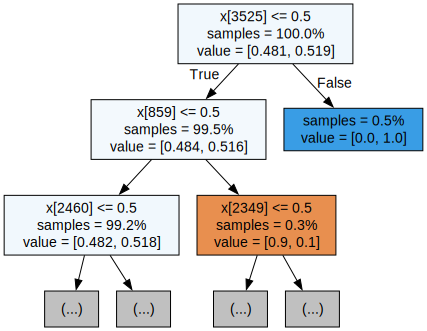

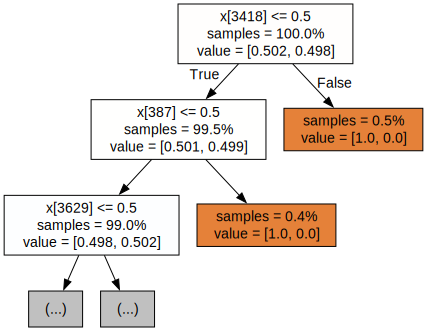

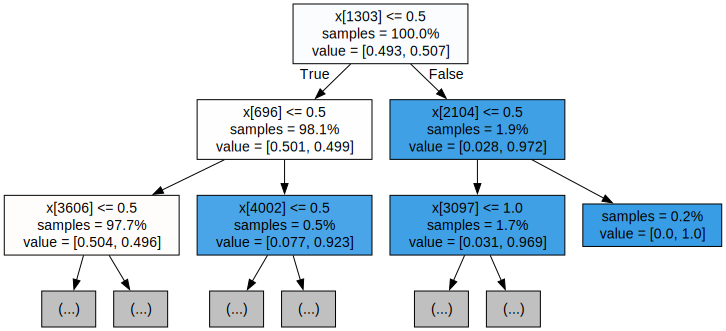

Best hyperparameters: {'max_depth': 18, 'n_estimators': 320}


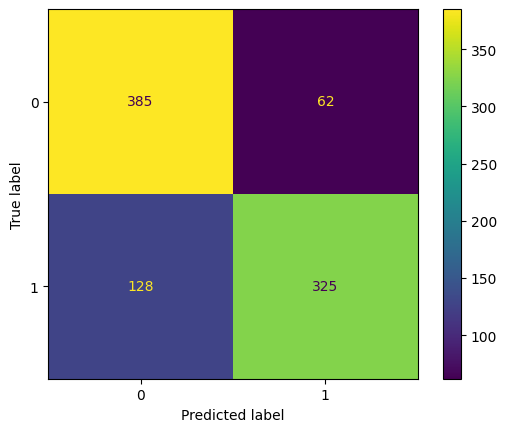

In [4]:
# Random Forrest Implementation
rf = RandomForestClassifier()
rf.fit(vector_sentiment_train, train_score)

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)t = best_rf_params['min_samples_split']
n_estimators = best_rf_params['n_estimators']
Best Parameters for Random Forest based on GridSearchCV: {'min_samples_split':
10, 'n_estimators': 70}
2.3.2 SVM Parameter Tuning
Here, I am using ‘linear’ kernel for SVC for this project
[20]: # Define Support Vector Machine parameters for grid search
param_grid_svc = {"kernel": ["linear"], "C": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
# Create Support Vector Machine model
svc_classifier = SVC()

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create another random forest classifier
# rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=10)

# Fit the random search object to the data
rand_search.fit(vector_sentiment_train, train_score)
# # Create a variable for the best model
best_rf = rand_search.best_estimator_

# # Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

#Confusion Matrix setup, prediction with the best models
predicted_score_best_rf = best_rf.predict(vector_sentiment_test)
cm_rf = confusion_matrix(test_score, predicted_score_best_rf)

ConfusionMatrixDisplay(confusion_matrix=cm_rf).plot();

Best Hyperparameters:  {'C': np.float64(0.4621657327250238), 'gamma': np.float64(10.985411419875572), 'kernel': 'linear'}


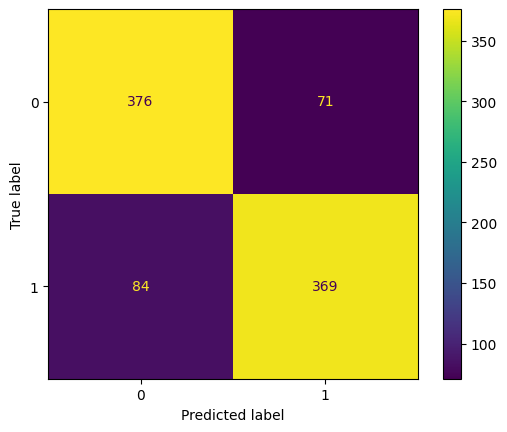

In [5]:
# Support Vector Machine Implementation
svm = SVC()
param_dist = {
    'C': uniform(0.1, 10),  # Uniform distribution between 0.1 and 10
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 50))
}
randomized_search = RandomizedSearchCV(estimator=svm, param_distributions=param_dist, n_iter=10, cv=10)

randomized_search.fit(vector_sentiment_train, train_score)

print("Best Hyperparameters: ", randomized_search.best_params_)
best_svm = randomized_search.best_estimator_

predicted_score_best_svm = best_svm.predict(vector_sentiment_test)
cm_svm = confusion_matrix(test_score, predicted_score_best_svm)

ConfusionMatrixDisplay(confusion_matrix=cm_svm).plot();

# # Scatter plot
# plt.scatter(X[:, 0], X[:, 1], 
#             c=y, 
#             s=20, edgecolors="k")
# plt.show()



In [20]:
r_forrest_evaluate = []
svm_evaluate = []
metric_des = ['TP', 'TN', 'FP', 'FN', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision','F1_measure', 'Accuracy', 'Error_rate', 'BACC', 
              'TSS', 'HSS']
# Implement KFold cross validation (To be continued)
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
print(k_fold.split(X))
iter = 0
for tr_index, ts_index in k_fold.split(X):
    iter += 1
    print(f'Iteration {iter}')
    print(best_rf.max_depth)
    rf_model_iter = RandomForestClassifier(max_depth=best_rf.max_depth, n_estimators=best_rf.n_estimators)
    train_sentiment, test_sentiment = X[tr_index], X[ts_index]
    train_score, test_score = y[tr_index], y[ts_index]
    vectorizer_inx = CountVectorizer()
    vector_sentiment_train_inx = vectorizer_inx.fit_transform(train_sentiment)
    vector_sentiment_test_inx = vectorizer_inx.transform(test_sentiment)
    rf_model_iter.fit(vector_sentiment_train_inx, train_score)
    predicted_rf_inx = rf_model_iter.predict(vector_sentiment_test_inx)
    cm_rf_inx = confusion_matrix(test_score, predicted_rf_inx)
    rf_metric_inx = metrics_function(cm_rf_inx)
    evaluated_metrics = pd.DataFrame([rf_metric_inx], columns=metric_des, index=['RF'])
    print(evaluated_metrics.round(2).T)
    
    

<generator object _BaseKFold.split at 0x73c3eca82350>
Iteration 1
18
                RF
TP          119.00
TN          121.00
FP           43.00
FN           17.00
TPR           0.88
TNR           0.74
FPR           0.26
FNR           0.12
Precision     0.73
F1_measure    0.80
Accuracy      0.80
Error_rate    0.20
BACC          0.81
TSS           0.61
HSS           0.60
Iteration 2
18
                RF
TP          123.00
TN          117.00
FP           20.00
FN           40.00
TPR           0.75
TNR           0.85
FPR           0.15
FNR           0.25
Precision     0.86
F1_measure    0.80
Accuracy      0.80
Error_rate    0.20
BACC          0.80
TSS           0.61
HSS           0.60
Iteration 3
18
                RF
TP          134.00
TN          107.00
FP           43.00
FN           16.00
TPR           0.89
TNR           0.71
FPR           0.29
FNR           0.11
Precision     0.76
F1_measure    0.82
Accuracy      0.80
Error_rate    0.20
BACC          0.80
TSS           0.61
HSS     